# Load Libraries

In [1]:
from IPython.display import display
from numpy import loadtxt
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from sklearn import svm
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf

C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Load Data

In [2]:
df = pd.read_csv('preprocessed_data_cleanedish_post2017.csv')

# Data Preprocessing

In [3]:

def countAnalogousArrays(consecutiveDifference, lowerBound, upperBound):
    """
    Counts the number of arrays that are analogous to the given consecutiveDifference array,
    within the specified range [lowerBound, upperBound], while maintaining the differences between
    consecutive elements.

    Args:
        consecutiveDifference (list of int): List containing the desired consecutive differences.
        lowerBound (int): The lower bound of the elements in the analogous arrays.
        upperBound (int): The upper bound of the elements in the analogous arrays.

    Returns:
        int: The total number of analogous arrays that satisfy the given conditions.

    Note:
        An analogous array is an array in which the difference between consecutive elements matches
        the corresponding values in the consecutiveDifference list.

    """

    memo = {}  # Memoization dictionary for storing intermediate results
    totway = 0  # Total number of ways to construct analogous arrays

    def tempfunction(condif, i, pv, lb, ub, memo):
        """
        Recursive helper function to calculate the number of ways to construct analogous arrays.

        Args:
            condif (list of int): List of consecutive differences.
            i (int): Current index in the consecutiveDifference list.
            pv (int): Previous value in the analogous array.
            lb (int): Current lower bound for array elements.
            ub (int): Current upper bound for array elements.
            memo (dict): Memoization dictionary.

        Returns:
            int: The number of ways to construct analogous arrays.
        """
        if i == len(condif):
            return 1  # Base case: all differences matched, return 1 way

        if (i, pv) in memo:
            return memo[(i, pv)]  # Return cached result if available

        currdiff = condif[i]  # Current consecutive difference
        ways = 0  # Initialize the count of ways to construct the array

        # Iterate through possible next values within the specified range
        for nv in range(lb, ub + 1):
            if pv + currdiff == nv:  # Check if the difference matches
                ways += tempfunction(condif, i + 1, nv, lb, ub, memo)

        memo[(i, pv)] = ways  # Cache the result
        return ways

    # Iterate through possible starting values within the specified range
    for i in range(lowerBound, upperBound):
        totway += tempfunction(consecutiveDifference, 1, i, lowerBound, upperBound, memo)

    return totway  # Return the total number of ways to construct analogous arrays


In [4]:
def downsample(majority: pd.DataFrame, minority: pd.DataFrame, samples: int = 1000):
    """
    Downsamples the majority class and upsamples the minority class to create a balanced dataset.

    Args:
        majority (pd.DataFrame): DataFrame containing majority class samples.
        minority (pd.DataFrame): DataFrame containing minority class samples.
        samples (int): Number of samples to include in the upsampled and downsampled dataset.

    Returns:
        pd.DataFrame: A DataFrame with downsampled majority class and upsampled minority class samples.
    """
    
    # Downsample the majority class
    df_majority_downsampled = resample(majority, replace=False, n_samples=samples)

    # Upsample the minority class
    df_minority_upsampled = resample(minority, replace=True, n_samples=samples)

    # Combine the minority class with the downsampled majority class
    df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority_upsampled])

    return df_up_down_sampled


## Feature Selection

In [5]:
class FeatureReduction(object):
    """
    A class for performing feature selection using forward selection and backward elimination techniques.
    These techniques aim to identify a subset of features that contribute significantly to a target variable.
    """

    def __init__(self):
        pass

    @staticmethod
    def forward_selection(
        data: pd.DataFrame, target: pd.Series, significance_level: float = 0.05
    ) -> List[str]:
        """
        Performs forward selection feature selection technique.

        Args:
            data (pd.DataFrame): Input data containing features.
            target (pd.Series): Target variable to predict.
            significance_level (float): Significance level for feature inclusion.

        Returns:
            List[str]: List of selected feature names.
        """
        cols = set(data.columns)  # Set of all available feature columns
        forward_list = []  # List to store selected features incrementally

        data = sm.add_constant(data)  # Add constant column for the intercept term
        pv = {}  # Dictionary to store p-values for each feature

        # Iterate through each feature to calculate p-values
        for c in cols:
            results = sm.OLS(target, data[[c] + ['const']]).fit()
            pv[c] = results.pvalues[c]

        pv = list(pv.items())
        pv.sort(key=lambda x: x[1])  # Sort p-values in ascending order
        mn, mn_val = pv[0]  # Feature with the lowest p-value
        forward_list.append(mn)  # Add the selected feature to the forward list
        cols.remove(mn)  # Remove the selected feature from the available features

        # Continue selecting features while p-values are below significance level
        while True:
            pv = {}
            for c in cols:
                results = sm.OLS(target, data[[c] + forward_list + ['const']]).fit()
                pv[c] = results.pvalues[c]

            pv = list(pv.items())
            pv.sort(key=lambda x: x[1])  # Sort p-values in ascending order
            mn, mn_val = pv[0]

            if mn_val >= significance_level:
                break
            else:
                forward_list.append(mn)
                cols.remove(mn)

        return forward_list

    @staticmethod
    def backward_elimination(
        data: pd.DataFrame, target: pd.Series, significance_level: float = 0.05
    ) -> List[str]:
        """
        Performs backward elimination feature selection technique.

        Args:
            data (pd.DataFrame): Input data containing features.
            target (pd.Series): Target variable to predict.
            significance_level (float): Significance level for feature exclusion.

        Returns:
            List[str]: List of selected feature names.
        """
        cols = set(data.columns)  # Set of all available feature columns
        data = sm.add_constant(data)  # Add constant column for the intercept term

        # Iterate through backward elimination until no features are left
        while not data.empty:

            results = sm.OLS(target, data).fit()
            pv = results.pvalues  # P-values for each feature

            if pv.max() <= significance_level:
                break
            else:
                # Remove the feature with the highest p-value
                cols.remove(pv.idxmax())
                data = data.drop(pv.idxmax(), axis=1)

        return list(cols)  # Return the list of selected features after elimination


In [6]:
ds = downsample(df[df['top200'] == 0],df[df['top200'] == 1],5000)

In [7]:
#Drop Unused Columns
X = ds.loc[:, ds.columns != 'top200']
X = X.drop(['rand_idx', 'song_id','song_name','genres','genres','artists','id_artists','release_date'], axis=1)
y = ds['top200']

#Scale the data
scaler = MinMaxScaler()
X[list(X.columns)] = scaler.fit_transform(X[list(X.columns)])

#Feature selection
featureselection = FeatureReduction()
forward_features = featureselection.forward_selection(X, y)
backward_features = featureselection.backward_elimination(X, y)

# 
X_less_features = X[forward_features]
list2 = ['acousticness', 'danceability', 'duration_ms', 'explicit', 'followers_total', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity_total', 'valence']
X_less_features = X[list2]


## Train-Val-Test Split

In [8]:
# Split dataset into train, validation, test
X_new, X_test, y_new, y_test                  = train_test_split(X_less_features, y, test_size=0.20)#,random_state=109)  # 20% Test Set
X_train, X_validation, y_train, y_validation  = train_test_split(X_new, y_new, test_size=0.125,random_state=109) # 10% Validation Set

# Data Modeling

## SVM Model

In [9]:
# Fit Linear SVM Model
lin_svm_model = svm.SVC(kernel='linear')
lin_svm_model.fit(X_train, y_train)
lin_y_pred = lin_svm_model.predict(X_validation)

# Fit Poly Model
poly_svm_model = svm.SVC(kernel='poly')
poly_svm_model.fit(X_train, y_train)
poly_y_pred = poly_svm_model.predict(X_validation)

#Fit Rbf
rbf_svm_model = svm.SVC(kernel='rbf')
rbf_svm_model.fit(X_train, y_train)
rbf_y_pred = rbf_svm_model.predict(X_validation)

# Model Accuracy: how often is the classifier correct?
print("Kernel: SVM Linear       Accuracy:", metrics.accuracy_score(y_validation, lin_y_pred))

# Model Accuracy: how often is the classifier correct?
print("Kernel: SVM Polynomial   Accuracy:", metrics.accuracy_score(y_validation, poly_y_pred))

# Model Accuracy: how often is the classifier correct?
print("Kernel: SVM RBF          Accuracy:", metrics.accuracy_score(y_validation, rbf_y_pred))



Kernel: SVM Linear       Accuracy: 0.86
Kernel: SVM Polynomial   Accuracy: 0.858
Kernel: SVM RBF          Accuracy: 0.855


In [10]:
cm = pd.DataFrame(confusion_matrix(y_validation, lin_y_pred,labels=[0,1]))
cm.columns = pd.MultiIndex.from_product([['Prediction'], cm.columns.tolist()])
print("Kernel: Linear")
display(cm)

cm = pd.DataFrame(confusion_matrix(y_validation, poly_y_pred,labels=[0,1]))
cm.columns = pd.MultiIndex.from_product([['Prediction'], cm.columns.tolist()])
print("Kernel: Poly")
display(cm)

cm = pd.DataFrame(confusion_matrix(y_validation, rbf_y_pred,labels=[0,1]))
cm.columns = pd.MultiIndex.from_product([['Prediction'], cm.columns.tolist()])
print("Kernel: Rbf")
display(cm)

Kernel: Linear


Prediction     
           0    1
0        409   99
1         41  451

Kernel: Poly


Prediction     
           0    1
0        409   99
1         43  449

Kernel: Rbf


Prediction     
           0    1
0        405  103
1         42  450

## Random Forest

In [11]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42,max_depth=20,min_samples_split=int(len(X_train)/20),min_samples_leaf = int(len(X_train)/20))

# Train the model on training data
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_validation)
print("Random Forest Classifier       Accuracy:",metrics.accuracy_score(y_validation, rf_pred))

cm = pd.DataFrame(confusion_matrix(y_validation, rf_pred,labels=[0,1]))
cm.columns = pd.MultiIndex.from_product([['Prediction'], cm.columns.tolist()])
print("Kernel: Rbf")
display(cm)


Random Forest Classifier       Accuracy: 0.848
Kernel: Rbf


Prediction     
           0    1
0        409   99
1         53  439

In [13]:
print(len(df[df['top200'] == 0]))
print(len(df[df['top200'] == 1]))

51315
4849


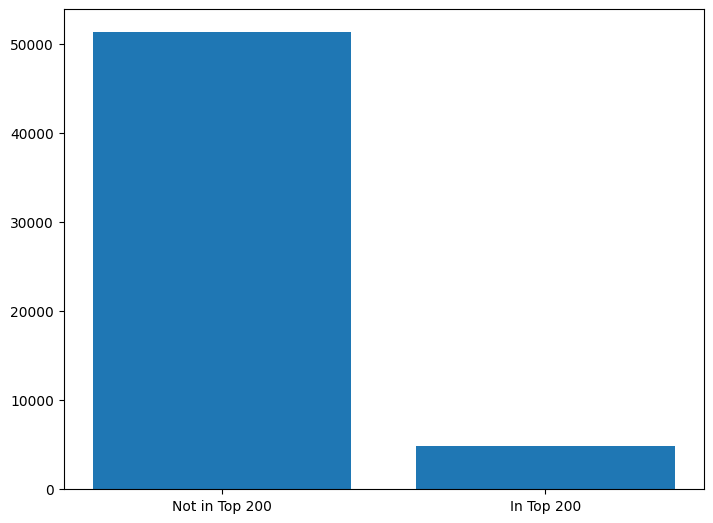

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ["Not in Top 200", "In Top 200"]
students = [len(df[df['top200'] == 0]),len(df[df['top200'] == 1])]
ax.bar(langs,students)
plt.show()

## Agglomerative Clustering

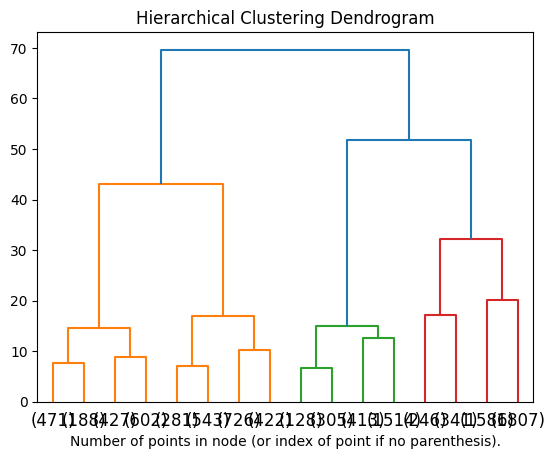

In [15]:
def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram using the linkage matrix from a hierarchical clustering model.

    Args:
        model: A fitted hierarchical clustering model.
        **kwargs: Additional keyword arguments to pass to the dendrogram function.
    """
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Create an AgglomerativeClustering model with distance_threshold=0 and no fixed number of clusters
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# Fit the model on the reduced feature dataset
model = model.fit(X_less_features)
# Set the plot title
plt.title("Hierarchical Clustering Dendrogram")
# Plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
# Set the x-axis label
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# Display the plot
plt.show()

## TSNE Visualization

[Text(0.5, 1.0, 'Spotify data T-SNE projection')]

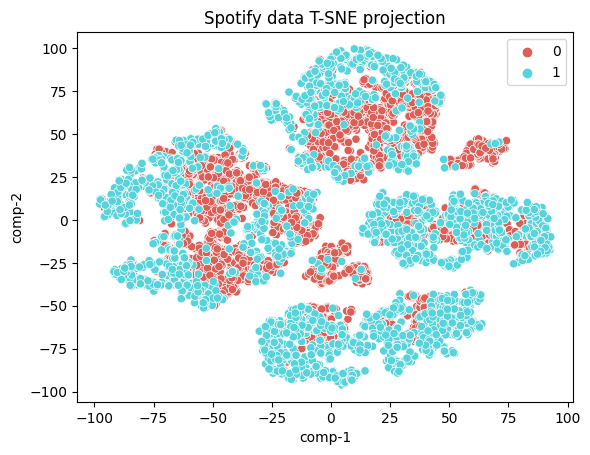

In [16]:
# Assign the feature matrix and target variable to variables x and y
x = X_less_features
# Initialize the TSNE model with 2 components, setting verbosity and random state
tsne = TSNE(n_components=2, verbose=0, random_state=123)
# Fit the TSNE model on the feature matrix and obtain the transformed data z
z = tsne.fit_transform(x)
# Create an empty DataFrame to store the transformed data along with target values
df = pd.DataFrame()
df["y"] = y  # Assign target variable to the "y" column
df["comp-1"] = z[:, 0]  # Assign the first component to the "comp-1" column
df["comp-2"] = z[:, 1]  # Assign the second component to the "comp-2" column
# Create a scatter plot using Seaborn's scatterplot function
sns.scatterplot(
    x="comp-1", y="comp-2", hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),  # Set color palette
    data=df
).set(title="Spotify data T-SNE projection")  # Set plot title


In [17]:
X_less_features.head()

,acousticness,danceability,duration_ms,explicit,followers_total,instrumentalness,key,liveness,loudness,mode,popularity_total,valence
39823,0.957831,0.404933,0.039883,0.0,0.070743,0.000004,0.636364,0.097480,0.651139,1.0,0.76,0.134420
45728,0.083634,0.868448,0.044675,0.0,0.006349,0.003940,0.727273,0.070116,0.837666,1.0,0.80,0.807536
54406,0.251003,0.938335,0.046019,0.0,0.001422,0.000226,0.090909,0.251342,0.930449,1.0,0.51,0.749491
9346,0.608433,0.601233,0.074714,0.0,0.000068,0.000000,0.454545,0.193515,0.877396,1.0,0.35,0.642566
54834,0.919679,0.244604,0.012258,0.0,0.000323,0.902000,0.545455,0.153242,0.489647,0.0,0.60,0.691446


## Neural Network

In [ ]:
# Iterate through a range of values for g (1 to 4)
for g in range(1, 5):
    # Define a dictionary containing hyperparameter values to test
    param = {
        "l1": [5, 10, 15],
        "l2": [3, 5, 8],
        "activation": ["relu", "sigmoid", "softmax", "tanh"],
        "optimizer": [
            tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001 * g),
            tf.keras.optimizers.Adam(learning_rate=0.001 * g),
        ],
    }
    # Initialize an empty list to store accuracy scores
    accs = []
    # Initialize a counter for tracking iterations
    count = 0
    # Iterate through combinations of hyperparameter values
    for a in param["l1"]:
        for b in param["l2"]:
            for c in param["activation"]:
                for d in param["activation"]:
                    for e in param["activation"]:
                        for f in param["optimizer"]:
                            # Build a sequential neural network model with specified hyperparameters
                            with tf.device("GPU"):
                                model = Sequential()
                                model.add(Dense(a, input_shape=(13,), activation=c))
                                model.add(Dense(b, activation=d))
                                model.add(Dense(1, activation=e))
                                
                                # Compile the Keras model with specified loss function and optimizer
                                model.compile(loss='binary_crossentropy', optimizer=f, metrics=['accuracy'])
                                
                                # Fit the Keras model on the training dataset
                                model.fit(X_train, y_train, epochs=5, batch_size=10, verbose=0)
                                
                                # Evaluate the model's accuracy on the test dataset
                                _, accuracy = model.evaluate(X_test, y_test)
                                
                                # Append the hyperparameter values and accuracy score to the list
                                accs.append([a, b, c, f, accuracy])
                                
                                # Print the current hyperparameter values for progress tracking
                                print(a, b, c, f)
                                
                                # Increment the counter
                                count += 1
                                
                                # Print progress after every 100 iterations
                                if count % 100 == 0:
                                    print("count" + str(count))


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Create a Sequential neural network model
model = Sequential()
# Add the first hidden layer with 15 neurons and tanh activation function
model.add(Dense(15, input_shape=(11,), activation="tanh"))
# Add the second hidden layer with 8 neurons and tanh activation function
model.add(Dense(8, activation="tanh"))
# Add the output layer with 1 neuron (binary classification) and tanh activation function
model.add(Dense(1, activation="tanh"))
# Compile the Keras model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
# Fit the Keras model on the training dataset
# using 5 epochs, batch size of 10, and setting verbose to 0 (no progress bar)
model.fit(X_train, y_train, epochs=5, batch_size=10, verbose=0)
# Evaluate the model's performance on the test dataset
# and store the loss and accuracy metrics in the underscore variable
_, accuracy = model.evaluate(X_test, y_test)
# Print the accuracy of the model on the test dataset
print(accuracy)


In [ ]:
NNdf = pd.DataFrame(accs, columns = ["Layer 1","Layer 1","Activation Function","Optimizer","Accuracy"])

In [ ]:
NNdf = NNdf.sort_values(by=['Accuracy'], ascending=False)
NNdf.head(15)

,Layer 1,Layer 1,Activation Function,Optimizer,Accuracy
0,5,3,relu,rmsprop,0.5145
50,15,3,sigmoid,rmsprop,0.5145
34,10,5,sigmoid,rmsprop,0.5145
35,10,5,sigmoid,adam,0.5145
1,5,3,relu,adam,0.5145
38,10,5,tanh,rmsprop,0.5145
39,10,5,tanh,adam,0.5145
40,10,8,relu,rmsprop,0.5145
41,10,8,relu,adam,0.5145
42,10,8,sigmoid,rmsprop,0.5145


## DBSCAN

In [ ]:
# List of epsilon values to test
temp = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]

# List of minimum samples values to test
temp2 = [2, 5, 10, 15, 20, 100, 500]

# List to store accuracy scores for each combination of hyperparameters
DBacc = []

# Iterate through epsilon values
for a in temp:
    # Iterate through minimum samples values
    for b in temp2:
        # Fit DBSCAN clustering model with current hyperparameters
        clustering = DBSCAN(eps=a, min_samples=b).fit(X_train)
        
        # Calculate accuracy score and append to the DBacc list
        DBacc.append(metrics.accuracy_score(y_train, clustering.labels_))


In [ ]:
print(max(DBacc)) # Print the best accuracy
print(DBacc) # Print entire matrix

0.5044285714285714
[0.22157143 0.49457143 0.50442857 0.50442857 0.50442857 0.50442857
 0.50442857 0.22157143 0.49457143 0.50442857 0.50442857 0.50442857
 0.50442857 0.50442857 0.22157143 0.49457143 0.50442857 0.50442857
 0.50442857 0.50442857 0.50442857 0.21914286 0.49385714 0.50442857
 0.50442857 0.50442857 0.50442857 0.50442857 0.21742857 0.49314286
 0.50442857 0.50442857 0.50442857 0.50442857 0.50442857 0.19814286
 0.48385714 0.50442857 0.50442857 0.50442857 0.50442857 0.50442857
 0.16271429 0.44757143 0.49842857 0.50442857 0.50442857 0.50442857
 0.50442857 0.043      0.044      0.044      0.044      0.04414286
 0.04928571 0.07357143 0.043      0.043      0.043      0.043
 0.043      0.043      0.043      0.49557143 0.49557143 0.49557143
 0.49557143 0.49557143 0.49557143 0.49557143 0.49557143 0.49557143
 0.49557143 0.49557143 0.49557143 0.49557143 0.49557143]


In [ ]:
DBacc = np.array(DBacc) # Cast into np array
print(np.unique(clustering.labels_)) # Check labels

[0]
